In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from qutip import *
import quimb as qi
from scipy.integrate import quad
from scipy.special import gamma
    
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)
plt.rc('figure', titlesize=20)

In [23]:
def genOps(dims):
    """Generate array of operators sigmax, sigmay, sigmaz in numpy array form i th element of sigmaxs is sigmax on the i th site."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    sigmaxs = []
    sigmays = []
    sigmazs = []

    for i in range(n):
        sigmaxs.append(np.array(qi.ikron(qi.pauli('X'), dims, i)))
        sigmays.append(np.array(qi.ikron(qi.pauli('Y'), dims, i)))
        sigmazs.append(np.array(qi.ikron(qi.pauli('Z'), dims, i)))

    return sigmaxs, sigmays, sigmazs

def genAOps(dims):
    """Generate array of operators a, adag in numpy array form i th element of a is a on the i th mode."""
    n = np.max(np.where(np.array(dims) == 2)) + 1  # number of sites
    m = len(dims) - n  # number of vibrational modes

    a = []
    adag = []

    for i in range(m):
        a.append(np.array(qi.ikron(qi.destroy(dims[n + i]), dims, n + i)))
        adag.append(np.array(qi.ikron(qi.create(dims[n + i]), dims, n + i)))

    return a, adag

def get_pops(tlist, nu_list, Gamma_list, kappa_list, nbar_list):
    
    Nmax = 10
    eps = 0.
    Delta = 1.

    dims = [2]
    for i in range(len(nu_list)):
        dims += [Nmax]
    sigmax, sigmay, sigmaz = genOps(dims)
    a, adag = genAOps(dims)

    H_mat = eps / 2 * sigmaz[0] + Delta / 2 * sigmax[0]
    for i in range(len(nu_list)):
        H_mat = H_mat + nu_list[i] * adag[i] @ a[i]
        H_mat = H_mat + kappa_list[i]/2 * sigmaz[0] @ (a[i] + adag[i])
    H = Qobj(H_mat, dims=[dims, dims])

    init_state = ket2dm(basis(2,0))
    for i in range(len(nbar_list)):
        init_state = tensor(init_state, thermal_dm(Nmax, nbar_list[i]))

    c_ops = []
    for i in range(len(nu_list)):
        c_op_mat = np.sqrt(Gamma_list[i]) * adag[i] @ a[i]
        c_ops += [Qobj(c_op_mat, dims=[dims, dims])]
        
    e_ops_mat = [sigmaz[0]]
    e_ops = [Qobj(e_op_mat, dims=[dims, dims]) for e_op_mat in e_ops_mat]

    result = mesolve(H, init_state, tlist, e_ops=e_ops, c_ops=c_ops)
    return np.array(result.expect[0] + 1)/2

In [24]:
# Generate qutip simulations of 2 mode approximation of each Leggett spectral density
s = 2
A = 0.1

sim_time = 12.8 * 2*np.pi
steps = 1280
tlist = np.linspace(0, sim_time, steps+1)

# optimized over 0.9 ~ 1.1. kappa < 0.2
def get_2mode_params(s):
    if s == 0.5:
        nu_list =  np.array([1.09129, 0.912179])
        Gamma_list = np.array([0.272822, 0.228045]) 
        kappa_list = np.array([0.181097, 0.14634])

    elif s == 1:
        nu_list =  np.array([1.09591, 0.915848])
        Gamma_list = np.array([0.273975, 0.228946]) 
        kappa_list = np.array([0.105528, 0.0788704])

    elif s == 2:
        nu_list = np.array([2.18909, 1.88611])
        Gamma_list = np.array([0.330522, 0.432952])
        kappa_list = np.array([0.2, 0.146257])
        
    return nu_list, Gamma_list, kappa_list

nu_list, Gamma_list, kappa_list = get_2mode_params(s)

# Assumes that first mode has phonon number 0.1
w_ref = 1.01
beta = np.log(1 + 1/0.1) / w_ref
nbar_list = 1 / (np.exp(beta * nu_list) - 1)
print(beta, nbar_list)

# qutip_pops = get_pops(tlist, nu_list, Gamma_list, kappa_list, nbar_list)
# np.save("Leggett_s=%.2f_A=%.2f_2modeapprox.npy"%(s, A), qutip_pops) 

2.3741537354439313 [0.0055626  0.01148753]


In [25]:
# used_seeds = np.arange(100, 120) - 100
# data = np.load("2mode_Leggett_s=2.0_seed100-139.npy")
# used_data = data[used_seeds, :]
# np.save("2mode_Leggett_s=2.0_seeds.npy", used_data)

In [26]:
def get_Ohmic(w, A, s, ν_c):
    return A * np.power(np.abs(w), s, dtype=float) * np.power(ν_c, 1-s, dtype=float) * np.exp(-np.abs(w) / ν_c) * np.sign(w)

def get_Lorentzian(wlist, nu_list, Gamma_list, kappa_list):
    fn = 0
    for i in range(len(nu_list)):
        nu = nu_list[i]
        Gamma = Gamma_list[i]
        fn += kappa_list[i]**2 * Gamma/2 * (1 / ((wlist - nu)**2 + (Gamma/2)**2) - 1 / ((wlist + nu)**2 + (Gamma/2)**2))   
    return fn

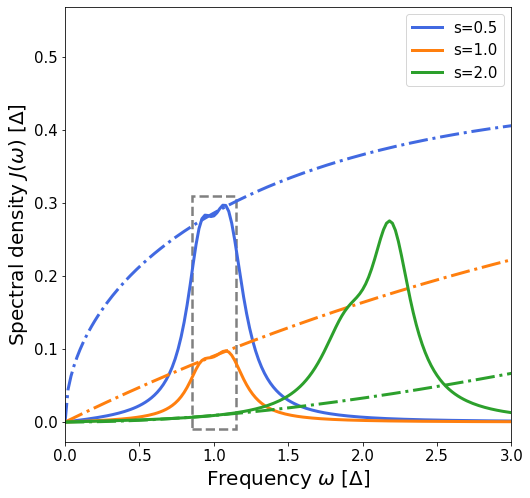

In [27]:
cutoff = 10
s_list = [0.5, 1., 2.]
w_list = np.linspace(0., 20., 1001)
color_list = ['royalblue', 'tab:orange', 'tab:green']

plt.subplots(figsize=(8,8))
for i in range(len(s_list)):
    s = s_list[i]
    sd = get_Ohmic(w_list, A, s, cutoff)    
    nu_list, Gamma_list, kappa_list = get_2mode_params(s)
    sd2 = get_Lorentzian(w_list, nu_list, Gamma_list, kappa_list)
    
    plt.plot(w_list, sd, '-.', color=color_list[i], linewidth=3)
    plt.plot(w_list, sd2, '-', color=color_list[i], linewidth=3, label='s=%.1f'%s)

import matplotlib.patches as patches
rect = patches.Rectangle((0.85, -0.01), 0.3, 0.32, linewidth=2.5, edgecolor='grey', linestyle='--', fill=False)
plt.gca().add_patch(rect)

plt.xlim((0, 3))
plt.xlabel(r'Frequency $\omega$ [$\Delta$]')
plt.ylabel(r'Spectral density $J(\omega)$ [$\Delta$]')
plt.legend();
plt.savefig('Figure4_11.png', dpi=300, bbox_inches='tight')

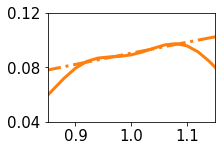

In [33]:
s_ind = 1  # 0 for s=0.5, 1 for s=1, 2 for s=2
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

fig, ax = plt.subplots(figsize=(3,2))
s = s_list[s_ind]
sd = get_Ohmic(w_list, A, s, cutoff)    
nu_list, Gamma_list, kappa_list = get_2mode_params(s)
sd2 = get_Lorentzian(w_list, nu_list, Gamma_list, kappa_list)

ax.plot(w_list, sd, '-.', label='s=%.1f'%s, color=color_list[s_ind], linewidth=3)
ax.plot(w_list, sd2, '-', color=color_list[s_ind],linewidth=3)
    
ax.set_xlim((0.85, 1.15))
ax.set_xticks([0.9, 1.0, 1.1])
if s_ind == 0:
    ax.set_ylim((0.15, 0.35))
    ax.set_yticks(np.linspace(0.15, 0.35, 3))
    plt.savefig('Figure4_12.png', dpi=300, bbox_inches='tight')
elif s_ind == 1:
    ax.set_ylim((0.04, 0.12))
    ax.set_yticks(np.linspace(0.04, 0.12, 3))
    plt.savefig('Figure4_13.png', dpi=300, bbox_inches='tight')
elif s_ind == 2:
    ax.set_ylim((0.005, 0.015))
    ax.set_yticks(np.linspace(0.005, 0.015, 3))
    plt.savefig('Figure4_14.png', dpi=300, bbox_inches='tight')

In [29]:
# Simulations have to be re-run with correct temperature
Leggett_pops_list = []
twomode_pops_list = []
sim_pops_list = []
for s in s_list:
    Leggett_pops_list += [np.load("Leggett_s=%.1f_A=0.10_cutoff10.npy"%s)]
    twomode_pops_list += [np.load("Leggett_s=%.1f_A=0.10_2modeapprox.npy"%s)]
    sim_pops_list += [np.load("2mode_Leggett_s=%.1f_noisy_seeds.npy"%s)]

In [30]:
exp_pops_list = []
exp_errorbars_list = []

def readFile(filename):
    timeTickFirst, timeTickLast, x, ion3, ion3_raw, ion3_bottom, ion3_top, ion4, ion4_raw, ion4_bottom, \
    ion4_top, ion5, ion5_raw, ion5_bottom, ion5_top, ion2, ion2_raw, ion2_bottom, ion2_top, ion6, ion6_raw, \
    ion6_bottom, ion6_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None,
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion4

def analyze(data_list):
    expdata_all = np.array(data_list).reshape((len(data_list), -1))
    expdata = np.mean(expdata_all, axis=0)
    
    variance = np.std(expdata_all, axis=0)**2 / len(data_list)
    shotnoise = np.maximum(np.sqrt(expdata_all * (1-expdata_all) / 100), 1e-3)
    variance = variance + np.mean(shotnoise**2, axis=0)
    errorbar = np.sqrt(variance)
    
    return expdata, errorbar


filenames = ['data_s0p5.xlsx', 'data_s1.xlsx', 'data_s2.xlsx']
for filename in filenames:
    df = pd.read_excel(filename)
    data_list = []
    for fname in df['Data']:
        if not (pd.isna(fname)):
            filename = fname
            _, pop = readFile(filename)
            data_list += [pop]
    expdata, errorbar  = analyze(data_list)
    exp_pops_list += [expdata]
    exp_errorbars_list += [errorbar]

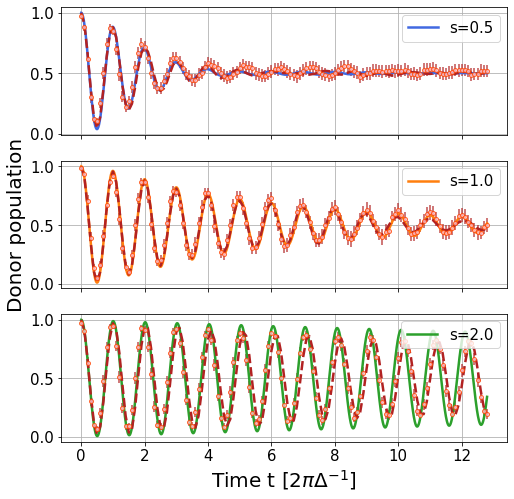

In [31]:
fig, ax = plt.subplots(3,1,figsize=(8,8))
color_list = ['royalblue', 'tab:orange', 'tab:green']
for s_ind in [0,1,2]: #0 for s=0.5, 1 for s=1, 2 for s=2
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    s = s_list[s_ind]
#     ax[s_ind].plot(tlist/2/np.pi, Leggett_pops_list[s_ind], '-', color=color_list[s_ind], linewidth = 2.5, label='s=%.1f'%s)
    ax[s_ind].plot(tlist/2/np.pi, twomode_pops_list[s_ind], '-', color=color_list[s_ind], linewidth = 2.5, label='s=%.1f'%s)
    ax[s_ind].plot(tlist[::10]/2/np.pi, np.mean(sim_pops_list[s_ind], axis=0), '--', linewidth = 2.5, color='firebrick')
    ax[s_ind].errorbar(tlist[::10]/2/np.pi, exp_pops_list[s_ind], yerr=exp_errorbars_list[s_ind], ls = '', alpha = 0.8, markersize=4,
                color = 'orangered', marker='o', ecolor='firebrick',mfc='pink')
    ax[s_ind].legend(loc='upper right')
    ax[s_ind].grid()
    ax[s_ind].label_outer()

ylabel = ax[1].set_ylabel('Donor population')
ax[2].set_xlabel(r'Time t [$2\pi\Delta^{-1}]$')
plt.savefig('Figure4_21.png', dpi=300, bbox_inches='tight')